In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from tensorflow import keras 
import cv2 


In [3]:
'''

Hi , here i am generarting a 3D microstructure from a 2D microstructure using this 
Research Paper(Link - https://www.sciencedirect.com/science/article/pii/S0010448520300993) 
as a part of my UnderGraduate Project .

'''

'\n\nHi , here i am generarting a 3D microstructure from a 2D microstructure using this \nResearch Paper(Link - https://www.sciencedirect.com/science/article/pii/S0010448520300993) \nas a part of my UnderGraduate Project .\n\n'

In [4]:
# import the VGG19 model to study 2D images 

vgg19_model = keras.applications.VGG19( weights = "imagenet" ,
                                       include_top = False , 
                                       input_shape = (224 , 224 ,3  ))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
'''

1. Generate a 3D Random micrsotrcuture . (random voxel values)
2. Generate 100 feature maps for each slice of this 3D microstructure (2D) . 
Calculate the Gram MAtrix of these feature maps of random micro.  ( G1 ) 

3. Generate 100 fetaure maps for the actual 2D image also . and calcualte
the gram amtrix of these feature maps of actual mcrsotrucre also ( G2 ) 

4. now , calcualte lss function b.w them (norm of  || G1 - G2 || )

5. Now , like  gradient descent ( l-BFGS) , update the pixel value (voxel) of the random 3D microstructe in 
every itr , update voxel values and gain repeat proces with next Slice of 3D microstrucr

and go on till G1 -G2 is minimzied , so the random 3D microstrucre looks like 
the 2D image at every angle . 



IMPORTANT  -  RESIZE  IMAGE ACCORDING TO ITS ORIGINAL SCALE . 

'''

'\n\n1. Generate a 3D Random micrsotrcuture . (random voxel values)\n2. Generate 100 feature maps for each slice of this 3D microstructure (2D) . \nCalculate the Gram MAtrix of these feature maps of random micro.  ( G1 ) \n\n3. Generate 100 fetaure maps for the actual 2D image also . and calcualte\nthe gram amtrix of these feature maps of actual mcrsotrucre also ( G2 ) \n\n4. now , calcualte lss function b.w them (norm of  || G1 - G2 || )\n\n5. Now , like  gradient descent ( l-BFGS) , update the pixel value (voxel) of the random 3D microstructe in \nevery itr , update voxel values and gain repeat proces with next Slice of 3D microstrucr\n\nand go on till G1 -G2 is minimzied , so the random 3D microstrucre looks like \nthe 2D image at every angle . \n\n\n\nIMPORTANT  -  RESIZE  IMAGE ACCORDING TO ITS ORIGINAL SCALE . \n\n'

In [6]:
!pip install noise

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for noise: filename=noise-1.2.2-cp310-cp310-linux_x86_64.whl size=30161 sha256=aaca4183eb889cc70b1b24b43413d8956d44ff417514cae4313a80e2125e3ad4
  Stored in directory: /root/.cache/pip/wheels/b2/01/64/ca2f6ed556c204d5ce2d3719a58757a5504aeb5525654692d0
Successfully built noise


Black Volume Fraction: 0.2188
White Volume Fraction: 0.7812


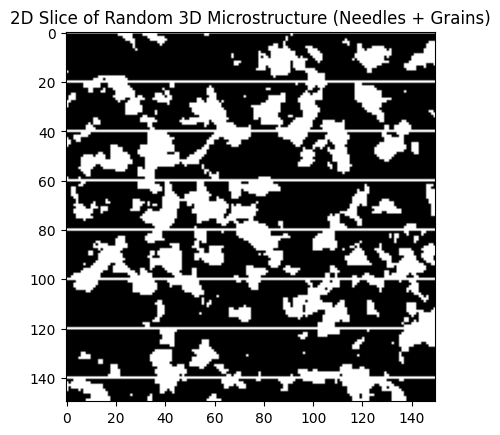

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from noise import pnoise3

# Parameters
height, width, depth = 150, 150, 150
scale = 10  # Scale for fractal noise
threshold = 0.4 # Adjusted threshold for balanced black/white regions

# Step 1: Generate normalized fractal noise
random_3d_micro = np.zeros((height, width, depth))
for x in range(height):
    for y in range(width):
        for z in range(depth):
            noise_val = pnoise3(x / scale, y / scale, z / scale, octaves=3)
            random_3d_micro[x, y, z] = noise_val

# Normalize fractal noise to [0, 1]
random_3d_micro = (random_3d_micro - np.min(random_3d_micro)) / (np.max(random_3d_micro) - np.min(random_3d_micro))

# Threshold to create black grains
black_grains = (random_3d_micro < threshold).astype(np.uint8)

# Step 2: Add straight black needles
black_needles = np.zeros((height, width, depth), dtype=np.uint8)

# Add vertical needles
for x in range(0, height, 20):  # Control spacing between needles
    black_needles[x, :, depth // 2] = 1  # Add a vertical line in the middle slice

# Add horizontal needles
for y in range(0, width, 30):  # Control spacing between needles
    black_needles[:, y, depth // 3] = 1  # Add horizontal lines in another slice

# Add diagonal needles
for d in range(min(height, width, depth)):
    black_needles[d, d, d] = 1  # Diagonal through the 3D matrix

# Step 3: Combine grains and needles into a white matrix
combined_structure = np.clip(black_grains + black_needles, 0, 1)  # Ensure binary values (0 or 1)

# Step 4: Compute volume fractions
black_fraction = np.sum(combined_structure) / combined_structure.size
white_fraction = 1 - black_fraction

print(f"Black Volume Fraction: {black_fraction:.4f}")
print(f"White Volume Fraction: {white_fraction:.4f}")

# Step 5: Visualize a slice
random_2d_slice = combined_structure[:, :, depth // 2]
plt.imshow(random_2d_slice, cmap="gray")
plt.title("2D Slice of Random 3D Microstructure (Needles + Grains)")
plt.show()


In [8]:

from keras.preprocessing.image import img_to_array, array_to_img

#select a slcie of 3D structure and convert into RGB format 
# def select_slice ( slice ) :
#     slice_resized = array_to_img( slice).resize( ( 224 , 224 ))
#     slice_resized  = img_to_array(slice_resized)

# # if grayscale , cobvert 2 RGB by repeating it 3 times 
#     # slice_rgb = np.stack((slice_resized,)*3, axis=-1) 
#     slice_rgb = slice_resized 
    
#     # preprocess for VGG19 
#     slice_rgb = keras.applications.vgg19.preprocess_input ( slice_rgb)
#     return slice_rgb 


from keras.utils import array_to_img, img_to_array
import numpy as np

def select_slice(slice):
    # Ensure the slice has a channel dimension
    if slice.ndim == 2:  # If the slice is 2D, add a channel dimension
        slice = np.expand_dims(slice, axis=-1)

    # Convert to image and resize to (224, 224)
    slice_resized = array_to_img(slice).resize((224, 224))
    slice_resized = img_to_array(slice_resized)

    # If grayscale, convert to RGB by repeating it 3 times
    if slice_resized.shape[-1] == 1:  # Grayscale image
        slice_resized = np.repeat(slice_resized, 3, axis=-1)

    return slice_resized


In [9]:



slice_rgb = select_slice( random_2d_slice)

In [10]:
# extract feature maps for the 2D slice of random microstructure 

# feature maps -  extracted ONLY from the  Convolution LAyer 
layer_vgg19 = [ layer.name for layer in vgg19_model.layers if 'conv' in layer.name ]

# make my own custom Feature Extractor Model 
# takes Feature MAp from ALAL the Intermediate LAyers 
feature_extractor  = keras.models.Model ( inputs  = vgg19_model.input , 
                                        outputs  = [vgg19_model.get_layer( name ).output 
                                                   for name in layer_vgg19 ])

# make a batch of 1 IMAGE SLICE ( for feature extraction from VGG19 model )
slice_rgb_batch = np.expand_dims( slice_rgb , axis= 0 )

feature_maps_one_slice  = feature_extractor.predict( slice_rgb_batch )

# feature_maps_one_slice[0]

I0000 00:00:1732947937.882851      94 service.cc:145] XLA service 0x7cd93800b0f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732947937.882910      94 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


I0000 00:00:1732947939.832469      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [11]:
feature_maps_one_slice[0][0].shape

(224, 224, 64)

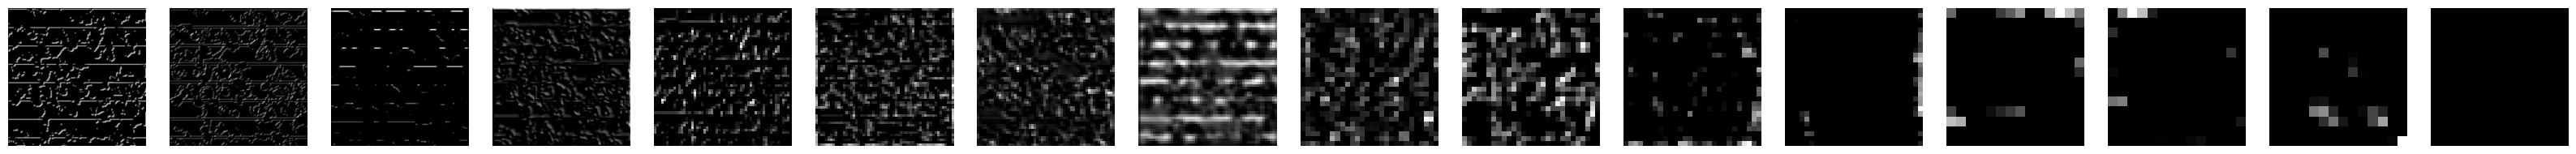

In [12]:

import matplotlib.pyplot as plt

# Example: Assuming feature_maps_one_slice contains images
num_images = len(feature_maps_one_slice)  # Number of images to display

# Create a single-row subplot with reduced figure size for smaller images
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))  # Adjust figsize as needed

for i in range(num_images):
    ax = axes[i]  # Get the corresponding subplot axis
    ax.imshow(feature_maps_one_slice[i][0][:, :, 0], cmap='gray')  # Display the image
    ax.axis('off') 

# Adjust layout
plt.tight_layout()
plt.show()


In [13]:
from PIL import Image 

# Load actual 2D image 

def load_tiff_img( path ) :
    
    tiff_image = Image.open( path ).convert('RGB')
    tiff_img_resized = tiff_image.resize( (224 ,224 ))

    #preprocesing for VGG19 
    img = img_to_array ( tiff_img_resized )
    tiff_image = keras.applications.vgg19.preprocess_input ( img )


    tiff_image_batch = np.expand_dims( tiff_image , axis=0 )
    
    return tiff_image_batch

In [14]:

# convert to a batch of tiff actual 2D microstructure image 

# batch of 1 image 
tiff_img_batch = load_tiff_img('/kaggle/input/images-tiff/micc_0.tif')



In [15]:
# Feature MAp vector for the ACTUAL 2D microstructure image 

feature_maps_actual_micro  = feature_extractor.predict( tiff_img_batch )
# feature_maps_actual_micro[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [16]:
# Caculate Gram Mtrix of a Feature MAp within Itself . 

def Gram_Matrix ( feature_map_batch) :

    #dims of feature map BATCH 
    h ,w ,c = feature_map_batch.shape 
    
    # compress into 2D matrix 
    matrix = np.reshape( feature_map_batch , (( h *w ) , c) )

    # gram amtrix = A . A_transpose
    gram_matrix  = np.dot( matrix.T , matrix )

    return gram_matrix 




In [17]:
''' IMPORTANT

gram matrix ( VT . V) is Not a single value but a sqaure matrix of values 
showing correaltion b/w i th feature map and j th feature map. 


'''

' IMPORTANT\n\ngram matrix ( VT . V) is Not a single value but a sqaure matrix of values \nshowing correaltion b/w i th feature map and j th feature map. \n\n\n'

In [18]:
# calculate gram matrix of each individual feature map 


#CASE 1 - for actual 2D microstrcuture 

gram_matrices_actual_micro = []

for i , feature_map in enumerate( feature_maps_actual_micro ) :
    
    # if feature map exists , then only compute gram matrix 
    feature_map = feature_map[0] if feature_map.shape[0]==1  else feature_map

    gram=  Gram_Matrix ( feature_map)

    gram_matrices_actual_micro.append( gram )



# # CASE 2 - for RANDOM 2D SLICE 

gram_matrices_random_micro = []

for i , feature_map in enumerate( feature_maps_one_slice) :
    
    # if feature map exists , then only compute gram matrix 
    feature_map = feature_map[0] if feature_map.shape[0]==1  else feature_map

    gram=  Gram_Matrix ( feature_map)

    gram_matrices_random_micro.append( gram )
    

In [19]:
def loss_function ( gram_matrix_random , gram_matrix_actual ) :

    total_loss =0 
    
    for slice_gram , actual_gram in zip(gram_matrix_random , gram_matrix_actual) :
        # frobenius norm 
        loss =  np.linalg.norm(slice_gram -actual_gram, 'fro')**2
        # normalized the large loss value ( to prevent divrgence )
        loss/= np.product( slice_gram.shape)
        total_loss+=loss 

    total_loss/=len(gram_matrix_random)
    return total_loss

In [20]:
loss_function ( gram_matrices_random_micro , gram_matrices_actual_micro )


/tmp/ipykernel_30/2026372954.py:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  loss_function ( gram_matrices_random_micro , gram_matrices_actual_micro )


2.883287118540556e+18

In [21]:
# convert to tf object , the random 3D microstructure

initial_voxels = tf.Variable( random_3d_micro , dtype=tf.float32 )
# initial_voxels

In [22]:

shape = ( 150 , 150, 150  )

def loss_function_only(voxel_values_flat):
    # Reshape the flat voxel array back to 3D
    voxel_values_reshaped = voxel_values_flat.reshape(shape)
    
    # Select a 2D slice and prepare it for VGG19
    slice_2d = voxel_values_reshaped[:, :, voxel_values_reshaped.shape[2] // 2]  # Get a 2D slice
    slice_rgb = np.stack((slice_2d,) * 3, axis=-1)  # Convert grayscale to RGB if needed

    
    slice_rgb_batch = np.expand_dims(slice_rgb, axis=0)  # Shape becomes (1, 224, 224, 3)

    feature_maps_random = feature_extractor.predict(slice_rgb_batch)

    # Calculate Gram matrices for each feature map  from each 2D slce of random 3D microstructure ) 
    # calcualted m times 
    gram_matrices_random = [Gram_Matrix(fm[0]) for fm in feature_maps_random]  # Remove batch dimension for each

    # differenc eb/w gram matrices of feature maps for 2D iamge and 3D microstructure slices.
    
    # Calculate the loss with Gram matrices of the actual microstructure
    total_loss = loss_function(gram_matrices_random, gram_matrices_actual_micro)
    return total_loss


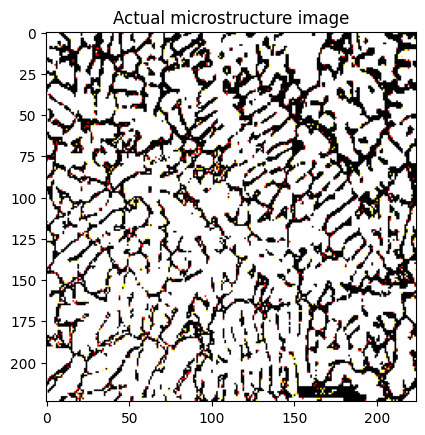

In [23]:
plt.imshow( tiff_img_batch[0] )
plt.title('Actual microstructure image')
plt.show()

In [26]:
def hierarchical_loss_function(voxel_values_flat):
    voxel_values_reshaped = voxel_values_flat.reshape(shape)
    coarse_loss = Gram_Matrix(downsample(voxel_values_reshaped, factor=4))
    fine_loss = Gram_Matrix(voxel_values_reshaped)
    return 0.5 * coarse_loss + 0.5 * fine_loss 

In [25]:
# optimize voxel values of the random 3D microstructure 

import scipy

# l_ BFGS algo optimizes these voxel values 

result = scipy.optimize.minimize(
        loss_function_only,   # Only the loss function, no gradients needed
        x0=random_3d_micro.flatten(),  # Initial flattened voxel values
        bounds=[(0, 255)] * random_3d_micro.size,
        method='L-BFGS-B',
    # Play with these Hyperparams , especially No of iterations , epsilon ,tolerance ,etc
        options={'maxiter': 10000 ,'ftol':1e-6 , 'eps':1e-8 , 'disp': False }# dont show me the iter 
    )

# Reshape optimized voxel values back to 3D
optimized_voxel_values = result.x.reshape(shape)

optimized_voxel_values

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


/tmp/ipykernel_30/3724550280.py:23: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  total_loss = loss_function(gram_matrices_random, gram_matrices_actual_micro)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

In [ ]:
# optimized_voxel_values = combined_structure

In [ ]:
# import numpy as np
# from scipy.ndimage import zoom
# import matplotlib.pyplot as plt

# # Assume the input image is loaded as a numpy array of shape (1, 224, 224, 224)
# # For demonstration, we'll generate a random array with similar dimensions
# input_image = tiff_img_batch[0]  # Replace this with your actual data

# # Remove the batch dimension
# input_image = input_image  # Now the shape is (224, 224, 224)

# # Target shape for the microstructure
# target_shape = (150, 150, 150)

# # Compute zoom factors
# #zoom_factors = [target / original for target, original in zip(target_shape, input_image.shape)]

# # Resize the 3D volume to the target shape
# microstructure_3d = zoom(input_image, zoom_factors, order=1)  # Linear interpolation

# # Visualize a central slice of the 3D microstructure (optional)
# # plt.imshow(microstructure_3d[:, :, target_shape[2] // 2], cmap="gray")
# # plt.title("Central Slice of Resized 3D Microstructure")
# # plt.show()

# # Verify the shape
# print("Original shape:", input_image.shape)
# print("Resized shape:", microstructure_3d.shape)


In [ ]:
optimized_voxel_values.shape

In [ ]:

# reconstrcuting back the 3D microstructure 
original_shape_micro = ( combined_structure.shape )  

reconstructed_microstructure = optimized_voxel_values.reshape( ( 150,150,150 ))

#converting voxel values to bianry
thresh = 125
binary_voxel_values = np.where(optimized_voxel_values > thresh, 1, 0)

In [ ]:
np.save('reconstructed_microstructure_4.npy', reconstructed_microstructure)

# np.save('binary_microstructure_2.npy', binary_voxel_values)

In [ ]:
original = tiff_img_batch[0]

def add_gaussian_noise(microstructure, mean=0, std=0.1):
    noise = np.random.normal(mean, std, microstructure.shape)
    noisy_microstructure = microstructure + noise
    noisy_microstructure = np.clip(noisy_microstructure, 0, 1)  # Ensure values remain within [0, 1]
    return noisy_microstructure
    
reconstructed  = random_2d_slice

In [ ]:
def plot_normalized_color_pdf(structure, title):
    # Flatten the structure to get color values
    colors = structure.flatten()

    # Calculate mean and standard deviation
    mean = np.mean(colors)
    std = np.std(colors)

    # Normalize colors to standard normal distribution
    normalized_colors = (colors - mean) / std

    # Plot the histogram of normalized colors
    plt.hist(normalized_colors, bins=256, density=True, color="blue", alpha=0.7)
    plt.title(f"{title} (Normalized)")
    plt.xlabel("Normalized Color Values")
    plt.ylabel("Density")
    plt.show()

    # Print summary statistics
    print(f"Mean (original): {mean}, Std Dev (original): {std}")
    print(f"Mean (normalized): {np.mean(normalized_colors):.2f}, Std Dev (normalized): {np.std(normalized_colors):.2f}")

# Plot normalized PDFs for original and reconstructed structures
plot_normalized_color_pdf(original, "Original")
plot_normalized_color_pdf(reconstructed, "Reconstructed")


In [ ]:
def compute_volume_fraction_original(image, threshold= 125):
    # Flatten the image to get all pixel values
    pixels = image.flatten()

    # Count black and white pixels
    black_pixels = np.sum(pixels < threshold)  # Below threshold = black
    total_pixels = pixels.size
    black_fraction = black_pixels / total_pixels

    # White fraction is the complement
    white_fraction = 1 - black_fraction

    return black_fraction, white_fraction


def compute_volume_fraction_reconstructed(image, threshold= 1):
    # Flatten the image to get all pixel values
    pixels = image.flatten()

    # Count black and white pixels
    black_pixels = np.sum(pixels < threshold)  # Below threshold = black
    total_pixels = pixels.size
    black_fraction = black_pixels / total_pixels

    # White fraction is the complement
    white_fraction = 1 - black_fraction

    return black_fraction, white_fraction
# Example: Compute for original and reconstructed images
original_black_frac, original_white_frac = compute_volume_fraction_original(original)
reconstructed_black_frac, reconstructed_white_frac = compute_volume_fraction_reconstructed(reconstructed)

print("Original Image Fractions:")
print(f"  Black Fraction: {original_black_frac:.4f}")
print(f"  White Fraction: {original_white_frac:.4f}")

print("Reconstructed Image Fractions:")
print(f"  Black Fraction: {reconstructed_black_frac:.4f}")
print(f"  White Fraction: {reconstructed_white_frac:.4f}")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
labels = ['Original', 'reconstructed']
original_fractions = [original_black_frac, reconstructed_black_frac ]
reconstructed_fractions = [original_white_frac , reconstructed_white_frac]

# Plot bar graph
x = np.arange(len(labels))  # Label positions
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(8, 6))

# Plot original fractions
ax.bar(x - width/2, original_fractions, width, label='Al', color='blue', alpha=0.7)

# Plot reconstructed fractions
ax.bar(x + width/2, reconstructed_fractions, width, label='Si', color='orange', alpha=0.7)

# Add labels, title, and legend
ax.set_ylabel('Volume Fraction')
ax.set_title('Volume Fractions (Al and Si )')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add values on top of bars
for i, v in enumerate(original_fractions):
    ax.text(i - width/2, v + 0.02, f'{v:.2f}', ha='center', fontsize=10)
for i, v in enumerate(reconstructed_fractions):
    ax.text(i + width/2, v + 0.02, f'{v:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import vtk
from vtk.util import numpy_support


# Load the .npy file
data = np.load('reconstructed_microstructure_4.npy')


# Get dimensions of the array
shape = data.shape

# Convert numpy array to VTK array
vtk_data_array = numpy_support.numpy_to_vtk(num_array=data.ravel(order='F'), deep=True, array_type=vtk.VTK_UNSIGNED_CHAR)

# Create VTK image data object
image_data = vtk.vtkImageData()
image_data.SetDimensions(shape)
image_data.SetSpacing(1.0, 1.0, 1.0)  # Adjust spacing if needed
image_data.GetPointData().SetScalars(vtk_data_array)

# Write the .vti file
writer = vtk.vtkXMLImageDataWriter()
writer.SetFileName("reconstructed_microstructure_12.vti")
writer.SetInputData(image_data)
writer.Write()




In [ ]:
# import numpy as np
# import vtk
# from vtk.util import numpy_support

# # Load the .npy file
# data = np.load('binary_microstructure_2.npy')

# # Get dimensions of the array
# shape = data.shape

# # Convert numpy array to VTK array
# vtk_data_array = numpy_support.numpy_to_vtk(num_array=data.ravel(order='F'), deep=True, array_type=vtk.VTK_UNSIGNED_CHAR)

# # Create VTK image data object
# image_data = vtk.vtkImageData()
# image_data.SetDimensions(shape)
# image_data.SetSpacing(1.0, 1.0, 1.0)  # Adjust spacing if needed
# image_data.GetPointData().SetScalars(vtk_data_array)

# # Write the .vti file
# writer = vtk.vtkXMLImageDataWriter()
# writer.SetFileName("binary_microstructure_2.vti")
# writer.SetInputData(image_data)
# writer.Write()



In [ ]:
# import numpy as np

# # Assume `binary_voxel_values` is the 3D binary voxel data with shape (nx, ny, nz)
# # Here, (nx, ny, nz) are the dimensions of the 3D voxel array

# nx, ny, nz = binary_voxel_values.shape
# voxel_size = 1.0  # Size of each voxel cube (you can change this to match your model scale)

# # Open a new INP file for writing
# with open("voxel_model.inp", "w") as f:
    
#     # Write heading information
#     f.write("*Heading\n")
#     f.write("** 3D Voxel Model generated from binary voxel data\n")
    
#     # Define nodes
#     f.write("*Node\n")
#     node_id = 1
#     node_map = {}

#     for x in range(nx + 1):
#         for y in range(ny + 1):
#             for z in range(nz + 1):
#                 # Define coordinates of the node
#                 x_coord = x * voxel_size
#                 y_coord = y * voxel_size
#                 z_coord = z * voxel_size
#                 f.write(f"{node_id}, {x_coord}, {y_coord}, {z_coord}\n")
                
#                 # Store node index mapping for later element definition
#                 node_map[(x, y, z)] = node_id
#                 node_id += 1
    
#     # Define elements (each voxel is a C3D8 hexahedral element)
#     f.write("*Element, type=C3D8\n")
#     element_id = 1

#     for x in range(nx):
#         for y in range(ny):
#             for z in range(nz):
#                 if binary_voxel_values[x, y, z] == 1:  # Only write elements for 'solid' voxels
#                     # Define element nodes based on voxel location
#                     n1 = node_map[(x, y, z)]
#                     n2 = node_map[(x + 1, y, z)]
#                     n3 = node_map[(x + 1, y + 1, z)]
#                     n4 = node_map[(x, y + 1, z)]
#                     n5 = node_map[(x, y, z + 1)]
#                     n6 = node_map[(x + 1, y, z + 1)]
#                     n7 = node_map[(x + 1, y + 1, z + 1)]
#                     n8 = node_map[(x, y + 1, z + 1)]
                    
#                     # Write the element and its nodes
#                     f.write(f"{element_id}, {n1}, {n2}, {n3}, {n4}, {n5}, {n6}, {n7}, {n8}\n")
#                     element_id += 1

#     # Define material and section properties for solid elements
#     f.write("*Solid Section, material=Material-1\n")
#     f.write("** Define sections for binary solid voxels\n")
#     f.write("*End Part\n")

#     # Material definition
#     f.write("*Material, name=Material-1\n")
#     f.write("*Elastic\n")
#     f.write("210000, 0.3\n")  # Example values for Young's modulus and Poisson's ratio

#     # Assembly and step definition
#     f.write("*Assembly\n")
#     f.write("*Instance, name=PART-1-1, part=PART-1\n")
#     f.write("*End Instance\n")
#     f.write("*End Assembly\n")

#     f.write("** Define analysis steps here if needed\n")



# # USe PAraView software to load it .

In [ ]:
# volume fraction 

#  VF fraction should be  -  93 and 7 Si 